In [58]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, BatchNormalization, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import tensorflow as tf 
print ("Done")

Done


In [60]:
!apt-get update
!apt-get install -y libsndfile1

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


# Importing Data 

                                              Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [61]:
#preparing data set

ravdess = "ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [62]:
Crema = "cremad/AudioWAV/"
Tess = "toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "surrey-audiovisual-expressed-emotion-savee/ALL/"

# preprocessing

**Ravdees**

In [63]:
file_emotion = []
file_path = []
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
    

In [64]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-01-01-01-01-24.wav
03
ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
8
03-01-08-02-02-02-24.wav


In [65]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust',
                             8:'surprise'},
                            inplace=True)
print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

  Emotions                                               Path
0  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
1  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
2  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
3  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
4  neutral  ravdess-emotional-speech-audio/audio_speech_ac...
______________________________________________
      Emotions                                               Path
1435  surprise  ravdess-emotional-speech-audio/audio_speech_ac...
1436  surprise  ravdess-emotional-speech-audio/audio_speech_ac...
1437  surprise  ravdess-emotional-speech-audio/audio_speech_ac...
1438  surprise  ravdess-emotional-speech-audio/audio_speech_ac...
1439  surprise  ravdess-emotional-speech-audio/audio_speech_ac...
_______________________________________________
Emotions
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dty

**Crema DataFrame**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [66]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.Emotions.value_counts())


Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


**TESS dataset**

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format

In [67]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())


Emotions
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64


**SAVEE Dataset**

Context
The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. This is supported by the cross-cultural studies of Ekman [6] and studies of automatic emotion recognition tended to focus on recognizing these [12]. We added neutral to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences.

Content
This results in a total of 120 utterances per speaker, for example:

Common: She had your dark suit in greasy wash water all year.
Anger: Who authorized the unlimited expense account?
Disgust: Please take this dirty table cloth to the cleaners for me.
Fear: Call an ambulance for medical assistance.
Happiness: Those musicians harmonize marvelously.
Sadness: The prospect of cutting back spending is an unpleasant one for any governor.
Surprise: The carpet cleaners shampooed our oriental rug.
Neutral: The best way to learn is to solve extra problems.

In [68]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df.Emotions.value_counts())


Emotions
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64


**Integration**

In [69]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,neutral,ravdess-emotional-speech-audio/audio_speech_ac...
1,neutral,ravdess-emotional-speech-audio/audio_speech_ac...
2,neutral,ravdess-emotional-speech-audio/audio_speech_ac...
3,neutral,ravdess-emotional-speech-audio/audio_speech_ac...
4,neutral,ravdess-emotional-speech-audio/audio_speech_ac...


In [70]:
print(data_path.Emotions.value_counts())

Emotions
happy       1923
sad         1923
angry       1923
fear        1923
disgust     1923
neutral     1895
surprise     652
Name: count, dtype: int64


>*                           Data Visualisation and Exploration

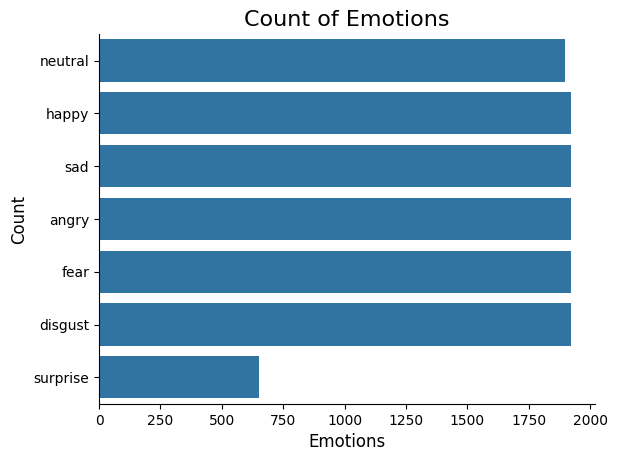

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [72]:
data,sr = librosa.load(file_path[0])
sr

22050

In [73]:
ipd.Audio(data,rate=sr)

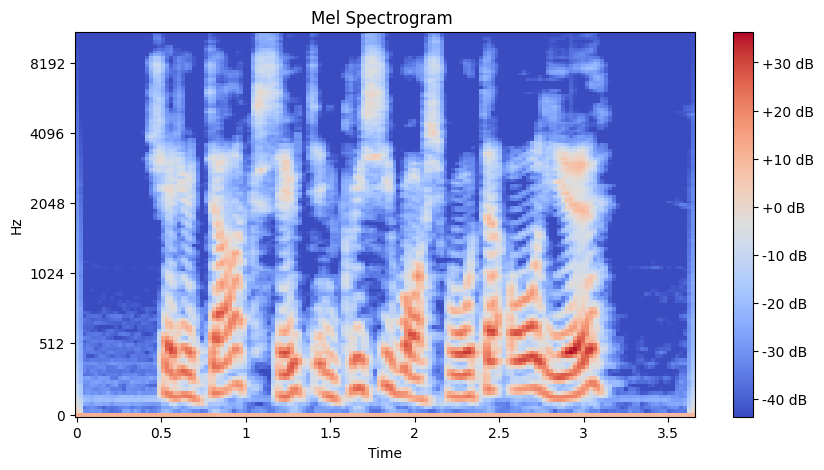

In [74]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

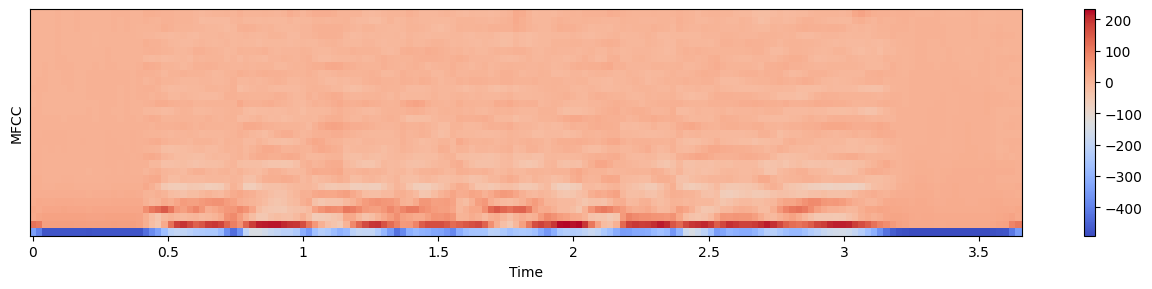

In [75]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

# Data augmentation

In [76]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

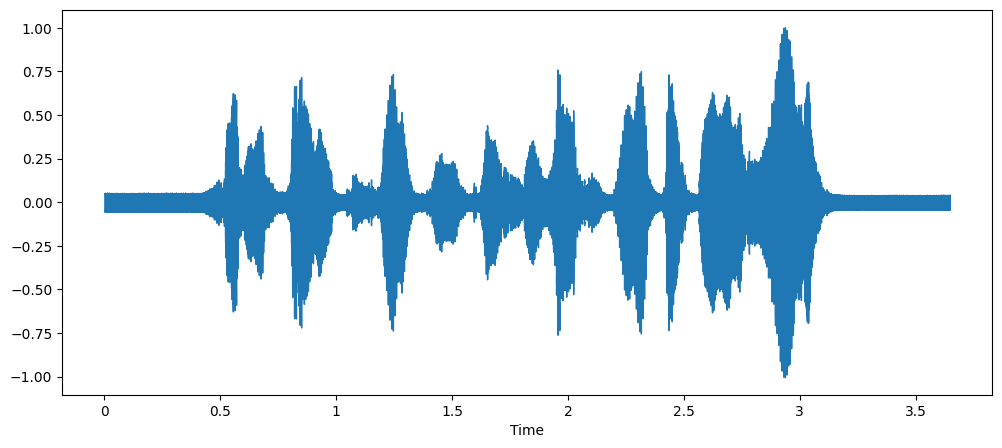

In [77]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

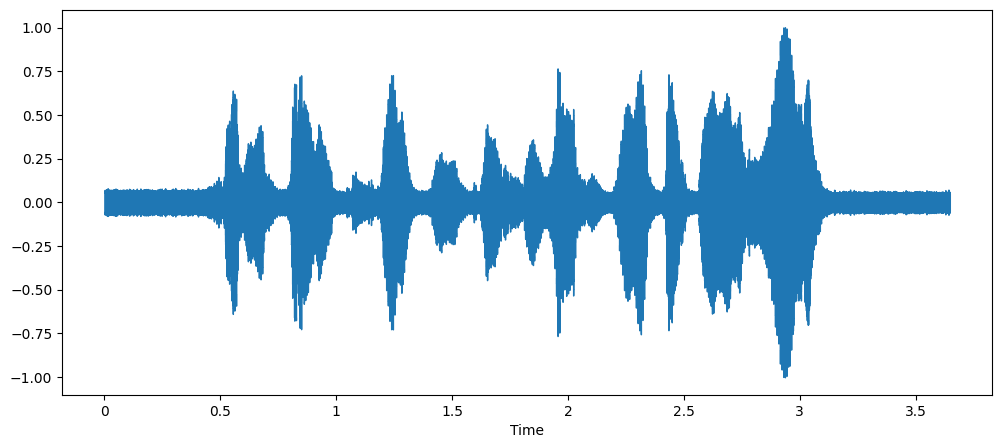

In [78]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [79]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

TypeError: time_stretch() takes 1 positional argument but 2 were given

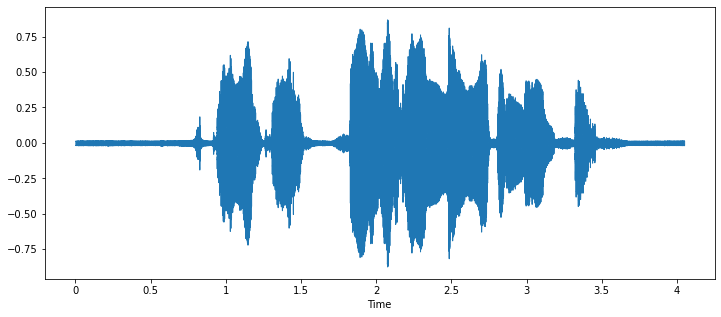

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

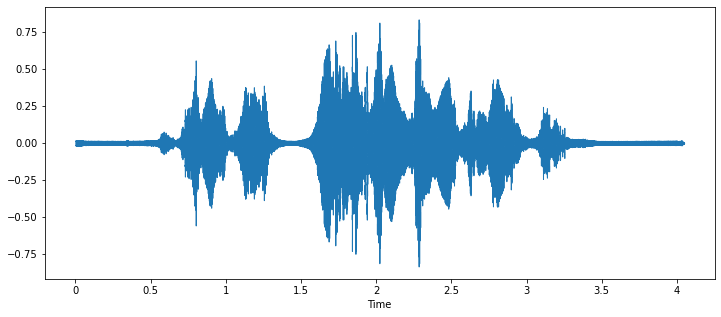

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sr)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

# Feature extraction

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio


In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


# Noraml way to get features

In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)         

0it [00:00, ?it/s]

0it [00:00, ?it/s]


TypeError: rms() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given

# Faster way to get features
***Parallel way***

**Dont be afraid from red lines that Normal**


This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.This code is an example of how to use the joblib library to process multiple audio files in parallel using the process_feature function. The code also uses the timeit library to measure the time taken to process the audio files.

Here's a breakdown of what the code does:

The from joblib import Parallel, delayed statement imports the Parallel and delayed functions from the joblib library.
The start = timeit.default_timer() statement starts a timer to measure the time taken to process the audio files.
The process_feature function processes a single audio file by extracting its features using the get_feat function and appending the corresponding X and Y values to the X and Y lists.
The paths and emotions variables extract the paths and emotions from the data_path DataFrame.
The Parallel function runs the process_feature function in parallel for each audio file using the delayed function to wrap the process_feature function.
The results variable contains the X and Y values for each audio file.
The X and Y lists are populated with the X and Y values from each audio file using the extend method.
The stop = timeit.default_timer() statement stops the timer.
The print('Time: ', stop - start) statement prints the time taken to process the audio files.
Overall, this code demonstrates how to use the joblib library to process multiple audio files in parallel, which can significantly reduce the processing time for large datasets.

*  The .extend() method increases the length of the list by the number of elements that are provided to the method, so if you want to add multiple elements to the list, you can use this method.

In [ ]:
"""from joblib import Parallel, delayed
import timeit
start = timeit.default_timer()
# Define a function to get features for a single audio file
def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)    """

"from joblib import Parallel, delayed\nimport timeit\nstart = timeit.default_timer()\n# Define a function to get features for a single audio file\ndef process_feature(path, emotion):\n    features = get_features(path)\n    X = []\n    Y = []\n    for ele in features:\n        X.append(ele)\n        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.\n        Y.append(emotion)\n    return X, Y\n\npaths = data_path.Path\nemotions = data_path.Emotions\n\n# Run the loop in parallel\nresults = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))\n\n# Collect the results\nX = []\nY = []\nfor result in results:\n    x, y = result\n    X.extend(x)\n    Y.extend(y)\n\n\nstop = timeit.default_timer()\n\nprint('Time: ', stop - start)    "

In [ ]:
len(X), len(Y), data_path.Path.shape


(0, 0, (12162,))

# Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,Emotions


In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,Emotions


In [ ]:
print(Emotions.isna().any())


Emotions    False
dtype: bool


In [ ]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

Emotions    False
dtype: bool


(0, 1)

In [ ]:
np.sum(Emotions.isna())

Emotions    0
dtype: int64

# Data preparation

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions


X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [ ]:
print(Y.shape)
X.shape

(0,)


(0, 0)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

> Applying early stopping for all models


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [ ]:

early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

# LSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

In [ ]:
"""model01=Sequential()
model01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))
model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.2))
model01.add(LSTM(128,return_sequences=True))
#model01.add(Dropout(0.3))
model01.add(LSTM(128))
#model01.add(Dropout(0.3))
model01.add(Dense(7,activation = 'softmax'))
model01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model01.summary()"""

"model01=Sequential()\nmodel01.add(LSTM(128,return_sequences=True,input_shape=(x_train.shape[1],1)))\nmodel01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.2))\nmodel01.add(LSTM(128,return_sequences=True))\n#model01.add(Dropout(0.3))\nmodel01.add(LSTM(128))\n#model01.add(Dropout(0.3))\nmodel01.add(Dense(7,activation = 'softmax'))\nmodel01.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])\nmodel01.summary()"

In [ ]:
"""hist=model01.fit(X_train, y_train,
            epochs=20,
            validation_data=(X_test, y_test),batch_size=64,
            verbose=1)"""

'hist=model01.fit(X_train, y_train,\n            epochs=20,\n            validation_data=(X_test, y_test),batch_size=64,\n            verbose=1)'

In [ ]:
"""print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

'print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")\nepochs = [i for i in range(20)]\nfig , ax = plt.subplots(1,2)\ntrain_acc = hist.history[\'accuracy\']\ntrain_loss = hist.history[\'loss\']\ntest_acc = hist.history[\'val_accuracy\']\ntest_loss = hist.history[\'val_loss\']\n\nfig.set_size_inches(20,6)\nax[0].plot(epochs , train_loss , label = \'Training Loss\')\nax[0].plot(epochs , test_loss , label = \'Testing Loss\')\nax[0].set_title(\'Training & Testing Loss\')\nax[0].legend()\nax[0].set_xlabel("Epochs")\n\nax[1].plot(epochs , train_acc , label = \'Training Accuracy\')\nax[1].plot(epochs , test_acc , label = \'Testing Accuracy\')\nax[1].set_title(\'Training & Testing Accuracy\')\nax[1].legend()\nax[1].set_xlabel("Epochs")\nplt.show()'

# CNN model

In [ ]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
#x_testcnn[0]

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [ ]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer
    
    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2376, 512)         3072      
_________________________________________________________________
batch_normalization (BatchNo (None, 2376, 512)         2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1188, 512)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1188, 512)         1311232   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1188, 512)         2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 594, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 594, 512)          0

In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
609/609 [==============================] - 116s 176ms/step - loss: 1.4134 - accuracy: 0.4612 - val_loss: 1.5701 - val_accuracy: 0.4272
Epoch 2/50
609/609 [==============================] - 106s 174ms/step - loss: 1.1311 - accuracy: 0.5590 - val_loss: 1.1125 - val_accuracy: 0.5736
Epoch 3/50
609/609 [==============================] - 106s 175ms/step - loss: 0.9911 - accuracy: 0.6172 - val_loss: 1.2060 - val_accuracy: 0.5508
Epoch 4/50
609/609 [==============================] - 106s 174ms/step - loss: 0.8980 - accuracy: 0.6541 - val_loss: 1.1263 - val_accuracy: 0.5845
Epoch 5/50
609/609 [==============================] - 106s 174ms/step - loss: 0.7886 - accuracy: 0.6979 - val_loss: 0.8593 - val_accuracy: 0.6742
Epoch 6/50
609/609 [==============================] - 106s 174ms/step - loss: 0.6691 - accuracy: 0.7490 - val_loss: 0.9310 - val_accuracy: 0.6601
Epoch 7/50
609/609 [==============================] - 106s 174ms/step - loss: 0.5480 - accuracy: 0.7971 - val_loss: 0.6999 -

305/305 [==============================] - 7s 24ms/step - loss: 0.1318 - accuracy: 0.9634
Accuracy of our model on test data :  96.34121060371399 %


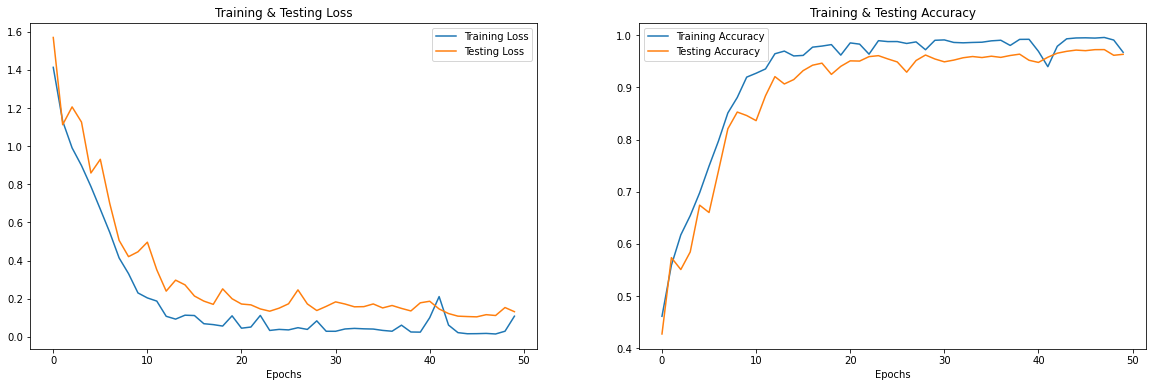

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
5,happy,happy
6,happy,happy
7,fear,fear
8,fear,fear
9,surprise,surprise


In [ ]:
df0

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,angry
2,disgust,disgust
3,happy,happy
4,fear,fear
...,...,...
9725,fear,fear
9726,disgust,disgust
9727,neutral,neutral
9728,sad,sad


Some plots of multi_model
______________________________________________


# CLSTM Model

Model that have lstm layers take alot of time if you have much free time enjoy with it

Another  model (CLSTM)  omnia model
_____________________________________________________

In [ ]:
#Build the model

# define model
"""model000 = Sequential()
model000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

          
model000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))

model000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model000.add(BatchNormalization())
model000.add(Dropout(0.3))
          
model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))

model000.add(LSTM(128, return_sequences=True)) 
model000.add(Dropout(0.3))
model000.add(LSTM(128))
model000.add(Dropout(0.3))

model000.add(Dense(128, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(64, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(32, activation='relu'))
#model000.add(Dropout(0.3))

model000.add(Dense(7, activation='softmax'))



model000.summary()"""

"model000 = Sequential()\nmodel000.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))\nmodel000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))\nmodel000.add(BatchNormalization())\nmodel000.add(Dropout(0.3))\n\n          \nmodel000.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))\nmodel000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))\nmodel000.add(BatchNormalization())\nmodel000.add(Dropout(0.3))\n\nmodel000.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))\nmodel000.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))\nmodel000.add(BatchNormalization())\nmodel000.add(Dropout(0.3))\n          \nmodel000.add(LSTM(128, return_sequences=True)) \nmodel000.add(Dropout(0.3))\n\nmodel000.add(LSTM(128, return_sequences=True)) \nmodel000.add(Dropout(0.3))\nmodel000.add(LSTM(128))\nmodel000.add(Dropout(0.3))\n\nmodel000.add(Dense(128, activatio

In [ ]:
"""from keras.utils.vis_utils import plot_model
plot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')"""

"from keras.utils.vis_utils import plot_model\nplot_model( model000, show_shapes=True, show_layer_names=True, to_file='model000.png')"

In [ ]:
"""model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"""

"model000.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"

In [ ]:
"""hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=40, validation_data=(x_testcnn, y_test))"""

'hist1=model000.fit(x_traincnn, y_train, batch_size=64, epochs=40, validation_data=(x_testcnn, y_test))'

In [ ]:
"""print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1,2)
train_acc = hist1.history['accuracy']
train_loss = hist1.history['loss']
test_acc = hist1.history['val_accuracy']
test_loss = hist1.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()"""

'print("Accuracy of our model on test data : " , model000.evaluate(x_testcnn,y_test)[1]*100 , "%")\nepochs = [i for i in range(40)]\nfig , ax = plt.subplots(1,2)\ntrain_acc = hist1.history[\'accuracy\']\ntrain_loss = hist1.history[\'loss\']\ntest_acc = hist1.history[\'val_accuracy\']\ntest_loss = hist1.history[\'val_loss\']\n\nfig.set_size_inches(20,6)\nax[0].plot(epochs , train_loss , label = \'Training Loss\')\nax[0].plot(epochs , test_loss , label = \'Testing Loss\')\nax[0].set_title(\'Training & Testing Loss\')\nax[0].legend()\nax[0].set_xlabel("Epochs")\n\nax[1].plot(epochs , train_acc , label = \'Training Accuracy\')\nax[1].plot(epochs , test_acc , label = \'Testing Accuracy\')\nax[1].set_title(\'Training & Testing Accuracy\')\nax[1].legend()\nax[1].set_xlabel("Epochs")\nplt.show()'

In [ ]:
# predicting on test data.
"""pred_test00 = model000.predict(x_testcnn)
y_pred00 = encoder.inverse_transform(pred_test)
y_test00 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred00.flatten()
df0['Actual Labels'] = y_test00.flatten()

df0.head(10)"""

"pred_test00 = model000.predict(x_testcnn)\ny_pred00 = encoder.inverse_transform(pred_test)\ny_test00 = encoder.inverse_transform(y_test)\n\n# Check for random predictions\ndf0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])\ndf0['Predicted Labels'] = y_pred00.flatten()\ndf0['Actual Labels'] = y_test00.flatten()\n\ndf0.head(10)"

# Evalutation

Results of best model

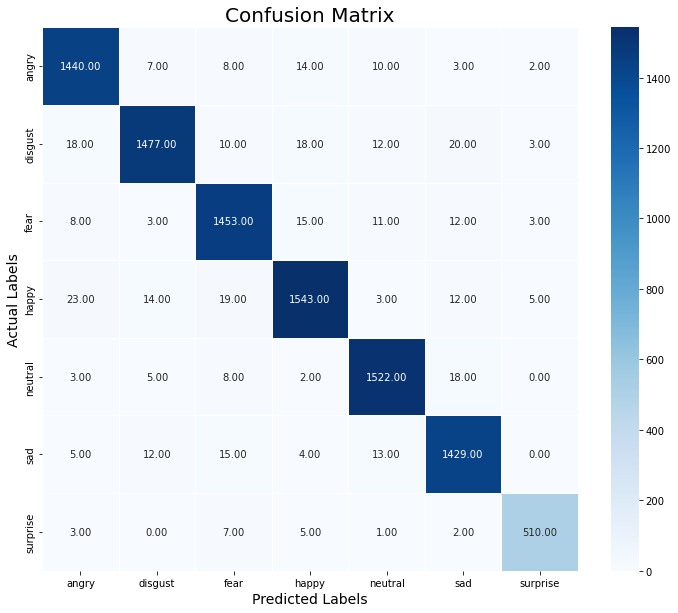

              precision    recall  f1-score   support

       angry       0.96      0.97      0.97      1484
     disgust       0.97      0.95      0.96      1558
        fear       0.96      0.97      0.96      1505
       happy       0.96      0.95      0.96      1619
     neutral       0.97      0.98      0.97      1558
         sad       0.96      0.97      0.96      1478
    surprise       0.98      0.97      0.97       528

    accuracy                           0.96      9730
   macro avg       0.96      0.96      0.96      9730
weighted avg       0.96      0.96      0.96      9730



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

# Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

Saved model to disk


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

305/305 [==============================] - 8s 24ms/step - loss: 0.1117 - accuracy: 0.9725
accuracy: 97.25%


# Saving and Loading our Stnadrad Scaler and encoder
* To save the StandardScaler object to use it later in a Flask API

pickle file


In [ ]:
import pickle

# Saving scaler
with open('scaler2.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open('scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open('encoder2.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open('encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


# Test script
* That can predict new record 

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
import pickle

with open('/kaggle/working/scaler2.pickle', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('/kaggle/working/encoder2.pickle', 'rb') as f:
    encoder2 = pickle.load(f)

    
print("Done")    

Done


In [ ]:
import librosa

In [ ]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)
    
    return final_result

In [ ]:
res=get_predict_feat("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")
print(res.shape)

(1, 2376, 1)


In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust',8:'Surprise'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder2.inverse_transform(predictions)
    print(y_pred[0][0])    

In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav")

neutral


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

neutral


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-05-01-02-02-01.wav")

angry


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_21/03-01-04-02-02-02-21.wav")

sad


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_02/03-01-06-01-02-02-02.wav")

fear


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-01-01.wav")

surprise


In [ ]:
prediction("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-07-01-01-01-01.wav")

disgust
